![alt text](gif.gif "Title")

# All-Time Great or Not. 

## Can we predict who is going to an NBA Hall Of Famer? By Brian Lau

Every year, the NBA helps elect fellow canadiates from all across the basketball scene to be inducted into the National Basketball Hall Of Fame. With more than 400 basketball legends inducted into the hall, a very good question to ask is whether a current day or recently retired NBA player will be inducted into the Hall Of Fame at some point after their career. Players selected for this prestigious honor (usually elected for a multitude of reason) are some of the most dominant players the league has ever seen. But is it possible to quantify whether or not someone will/will not be a Hall Of Famer? Let's find out.

I will attempt to use two machine learning algorithms to predict this and along the way show some interesting statistics/graphs about how dominant some of the people inducted into the Hall Of Fame just are compared to the average NBA player with the end goal of hopefully seeing if we can predict who is going to be awarded the coveted honor of Hall Of Famer one day.

### 1. Scraping The Data Set

We are going to need some basic packages in order to scrape the data we need to answer our million dollar question. We want to store our data in a Pandas dataframe which will make it easy to process and clean as needed later on! I attached some notes on every package I imported:

In [134]:
#Importing Pandas to utilize dataframes and other basic Excel-like operations
import pandas as pd
#Numpy to make working with dataframes and other basic Python operations a little easier
import numpy as np
#These two packages were used in conjunction to make scraping possible, more on this below.
import time
import os
#For graphing later on
import matplotlib.pyplot as plt
#Machine Learning Packages
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
#May need to "pip install wordcloud" but word cloud at the very end!
from wordcloud import WordCloud


#### Getting every NBA player statline from 1950-2022
To start and get every NBA player's stats, I opted to scrape the stats from every single year of every single player. Unfortunately, this means I would need to send roughly 73 requests to a website which lead me to get blocked multiple times for sending too many requests and get thrown on a cooldown. Luckily, with the help of the time package and the OS package, I was able to separate out my requests every 30 seconds to avoid getting blocked, at which point I stored the information in a .csv for any further iterations of the program in order to not have to wait 25 minutes to set up a data frame everytime. We will be getting all of our neccessary info from basketball-reference.com instead of a pre-built API

In [135]:
#Make it so we can see all the columns of a dataframe instead of just a preview
pd.set_option('display.max_columns', None)
#Supressing chained assignment warnings
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
#Ignoring warnings for a depreciation 
pd.options.mode.chained_assignment = None  
#Arranging the years from 1950 (when the league first started) to the last finished NBA season: 2021-2022.
years = np.arange(1950,2022)

#Setting up a list to add to our data set for each year and player stat line from that year.
listOfYears = []

#Scraping NBA Roster from Basketball Reference if needed
if(os.path.exists('roster.csv') == False):
    for year in years:
        #Loop through every year scraping all the stats from that year
        dfToAdd = pd.read_html('http://www.basketball-reference.com/leagues/NBA_'+str(year)+'_per_game.html')[0]
        #Sleep 30 seconds to avoid getting blocked
        time.sleep(30)
        #Add a year value column so we know which year each player statline is from.
        dfToAdd['Year'] = year
        #Add it to the list of years
        listOfYears.append(dfToAdd)
    #Finally append on the entire list to the dataframe.
    dfOfPlayers = pd.concat(listOfYears)
    #Storing it in a CSV to avoid getting blocked and needing to rerequest
    dfOfPlayers.to_csv('roster.csv')
else:
    #If the roster.csv file already exists then just read from it
    dfOfPlayers = pd.read_csv("roster.csv")
    
dfOfPlayers

,Unnamed: 0,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
0,0,1,Curly Armstrong,G-F,31,FTW,63,NaN,NaN,2.3,8.2,.279,NaN,NaN,NaN,2.3,8.2,.279,.279,2.7,3.8,.705,NaN,NaN,NaN,2.8,NaN,NaN,NaN,3.4,7.3,1950
1,1,2,Cliff Barker,SG,29,INO,49,NaN,NaN,2.1,5.6,.372,NaN,NaN,NaN,2.1,5.6,.372,.372,1.5,2.2,.708,NaN,NaN,NaN,2.2,NaN,NaN,NaN,2.0,5.7,1950
2,2,3,Leo Barnhorst,SF,25,CHS,67,NaN,NaN,2.6,7.4,.349,NaN,NaN,NaN,2.6,7.4,.349,.349,1.3,1.9,.698,NaN,NaN,NaN,2.1,NaN,NaN,NaN,2.9,6.5,1950
3,3,4,Ed Bartels,F,24,TOT,15,NaN,NaN,1.5,5.7,.256,NaN,NaN,NaN,1.5,5.7,.256,.256,1.3,2.3,.559,NaN,NaN,NaN,1.3,NaN,NaN,NaN,1.9,4.2,1950
4,4,4,Ed Bartels,F,24,DNN,13,NaN,NaN,1.6,6.3,.256,NaN,NaN,NaN,1.6,6.3,.256,.256,1.3,2.4,.548,NaN,NaN,NaN,1.5,NaN,NaN,NaN,2.1,4.5,1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28502,726,536,Delon Wright,PG,28,SAC,27,8,25.8,3.9,8.3,.462,1.2,3.1,.398,2.6,5.3,.500,.536,1.1,1.3,.833,1.0,2.9,3.9,3.6,1.6,0.4,1.3,1.1,10.0,2021
28503,727,537,Thaddeus Young,PF,32,CHI,68,23,24.3,5.4,9.7,.559,0.2,0.7,.267,5.3,9.1,.580,.568,1.0,1.7,.628,2.5,3.8,6.2,4.3,1.1,0.6,2.0,2.2,12.1,2021
28504,728,538,Trae Young,PG,22,ATL,63,63,33.7,7.7,17.7,.438,2.2,6.3,.343,5.6,11.3,.491,.499,7.7,8.7,.886,0.6,3.3,3.9,9.4,0.8,0.2,4.1,1.8,25.3,2021
28505,729,539,Cody Zeller,C,28,CHO,48,21,20.9,3.8,6.8,.559,0.1,0.6,.143,3.7,6.2,.598,.565,1.8,2.5,.714,2.5,4.4,6.8,1.8,0.6,0.4,1.1,2.5,9.4,2021


#### Getting the list of current hall of famers

In [136]:
#Grabbing list of past HOFers, very easy :) 
dfHOF = pd.read_html('https://www.basketball-reference.com/awards/hof.html')[0]
dfHOF

Unnamed: 0_level_0                                 Unnamed: 1_level_0  \
                  Year                                               Name   
0                 2022                                      Sonny Boswell   
1                 2022                                     Swin Cash WNBA   
2                 2022  Larry Costello Player / Coach / CBB player / C...   
3                 2022                                     Hugh Evans Ref   
4                 2022                       Manu Ginobili Player / Int'l   
..                 ...                                                ...   
567               1959                           James Naismith CBB coach   
568               1959                     Harold Olsen Coach / CBB coach   
569               1959                                      John Schommer   
570               1959                        Amos Alonzo Stagg CBB coach   
571               1959                                       Oswald Tower   

    Unnamed: 2_level_0 Unnamed: 3_level_0 Per Game                      \
              Category                  G      PTS  TRB  AST  STL  BLK   
0               Player                NaN      NaN  NaN  NaN  NaN  NaN   
1               Player                NaN      NaN  NaN  NaN  NaN  NaN   
2          Contributor                NaN      NaN  NaN  NaN  NaN  NaN   
3              Referee                NaN      NaN  NaN  NaN  NaN  NaN   
4               Player               1057     13.3  3.5  3.8  1.3  0.3   
..                 ...                ...      ...  ...  ...  ...  ...   
567        Contributor                NaN      NaN  NaN  NaN  NaN  NaN   
568        Contributor                NaN      NaN  NaN  NaN  NaN  NaN   
569             Player                NaN      NaN  NaN  NaN  NaN  NaN   
570        Contributor                NaN      NaN  NaN  NaN  NaN  NaN   
571        Contributor                NaN      NaN  NaN  NaN  NaN  NaN   

    Shooting             Advanced       Unnamed: 14_level_0 Coaching       \
         FG%   3P%   FT%       WS WS/48 Unnamed: 14_level_1        G    W   
0        NaN   NaN   NaN      NaN   NaN                 NaN      NaN  NaN   
1        NaN   NaN   NaN      NaN   NaN                 NaN      NaN  NaN   
2        NaN   NaN   NaN      NaN   NaN                 NaN      NaN  NaN   
3        NaN   NaN   NaN      NaN   NaN                 NaN      NaN  NaN   
4       .447  .369  .827    106.4  .190                 NaN      NaN  NaN   
..       ...   ...   ...      ...   ...                 ...      ...  ...   
567      NaN   NaN   NaN      NaN   NaN                 NaN      NaN  NaN   
568      NaN   NaN   NaN      NaN   NaN                 NaN      NaN  NaN   
569      NaN   NaN   NaN      NaN   NaN                 NaN      NaN  NaN   
570      NaN   NaN   NaN      NaN   NaN                 NaN      NaN  NaN   
571      NaN   NaN   NaN      NaN   NaN                 NaN      NaN  NaN   

               
       L W/L%  
0    NaN  NaN  
1    NaN  NaN  
2    NaN  NaN  
3    NaN  NaN  
4    NaN  NaN  
..   ...  ...  
567  NaN  NaN  
568  NaN  NaN  
569  NaN  NaN  
570  NaN  NaN  
571  NaN  NaN  

[572 rows x 19 columns]

## 2. Time To Clean! 

As you can tell, the datasets cannot be used in the current state they're in. They simply are way way wayyyyy too messy to be used for any data science experiments or performed any operations on in general. In this part of the data, we are going to need to do a lot of small miscellaneous things such as deleting unneccessary columns, casting certain columns to values, etc in order to prepare our data to be experimented on. To begin with, let us start with cleaning up our dataset of all NBA statlines since 1950.

In [137]:
### Deleting any unneccesary columns ###
del dfOfPlayers["Unnamed: 0"] 
del dfOfPlayers["GS"]
del dfOfPlayers["Rk"]
del dfOfPlayers["Age"]
del dfOfPlayers["Pos"]
del dfOfPlayers["Tm"]

### Casting Values ###

#We need to put the option of "coerce" which will cast any values that can't be casted into NaN
#which indicates that it is a bad row of data *there are some repeat rows where the header is just repeated as a value
dfOfPlayers['G'] = pd.to_numeric(dfOfPlayers['G'], errors = 'coerce')
dfOfPlayers = dfOfPlayers.dropna(subset=['G'])
dfOfPlayers['MP'] = pd.to_numeric(dfOfPlayers['MP'])
dfOfPlayers['MP'] = pd.to_numeric(dfOfPlayers['MP'])
dfOfPlayers['FG'] = pd.to_numeric(dfOfPlayers['FG'])
dfOfPlayers['FGA'] = pd.to_numeric(dfOfPlayers['FGA'])
dfOfPlayers['FG%'] = pd.to_numeric(dfOfPlayers['FG%'])
dfOfPlayers['3P'] = pd.to_numeric(dfOfPlayers['3P'])
dfOfPlayers['3PA'] = pd.to_numeric(dfOfPlayers['3PA'])
dfOfPlayers['3P%'] = pd.to_numeric(dfOfPlayers['3P%'])
dfOfPlayers['2P'] = pd.to_numeric(dfOfPlayers['2P'])
dfOfPlayers['2PA'] = pd.to_numeric(dfOfPlayers['2PA'])
dfOfPlayers['2P%'] = pd.to_numeric(dfOfPlayers['2P%'])
dfOfPlayers['eFG%'] = pd.to_numeric(dfOfPlayers['eFG%'])
dfOfPlayers['FT'] = pd.to_numeric(dfOfPlayers['FT'])
dfOfPlayers['FTA'] = pd.to_numeric(dfOfPlayers['FTA'])
dfOfPlayers['FT%'] = pd.to_numeric(dfOfPlayers['FT%'])
dfOfPlayers['ORB'] = pd.to_numeric(dfOfPlayers['ORB'])
dfOfPlayers['DRB'] = pd.to_numeric(dfOfPlayers['DRB'])
dfOfPlayers['TRB'] = pd.to_numeric(dfOfPlayers['TRB'])
dfOfPlayers['AST'] = pd.to_numeric(dfOfPlayers['AST'])
dfOfPlayers['STL'] = pd.to_numeric(dfOfPlayers['STL'])
dfOfPlayers['BLK'] = pd.to_numeric(dfOfPlayers['BLK'])
dfOfPlayers['TOV'] = pd.to_numeric(dfOfPlayers['TOV'])
dfOfPlayers['PF'] = pd.to_numeric(dfOfPlayers['PF'])
dfOfPlayers['PTS'] = pd.to_numeric(dfOfPlayers['PTS'])
dfOfPlayers['Year'] = pd.to_numeric(dfOfPlayers['Year'])

### Cleaning up the % values for any players with 0 attempts for things like free throws ###
dfOfPlayers['FG%'] = dfOfPlayers['FG%'].fillna(0)
dfOfPlayers['eFG%'] = dfOfPlayers['eFG%'].fillna(0)
dfOfPlayers['FT%'] = dfOfPlayers['FT%'].fillna(0)

### Hall Of Famers in the season stats are denoted with a * next to their name. Let's remove it
for index, row in dfOfPlayers.iterrows():
    if('*' in row['Player']):
        dfOfPlayers.at[index, 'Player'] = row['Player'][:-1]

dfOfPlayers

,Player,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
0,Curly Armstrong,63.0,NaN,2.3,8.2,0.279,NaN,NaN,NaN,2.3,8.2,0.279,0.279,2.7,3.8,0.705,NaN,NaN,NaN,2.8,NaN,NaN,NaN,3.4,7.3,1950
1,Cliff Barker,49.0,NaN,2.1,5.6,0.372,NaN,NaN,NaN,2.1,5.6,0.372,0.372,1.5,2.2,0.708,NaN,NaN,NaN,2.2,NaN,NaN,NaN,2.0,5.7,1950
2,Leo Barnhorst,67.0,NaN,2.6,7.4,0.349,NaN,NaN,NaN,2.6,7.4,0.349,0.349,1.3,1.9,0.698,NaN,NaN,NaN,2.1,NaN,NaN,NaN,2.9,6.5,1950
3,Ed Bartels,15.0,NaN,1.5,5.7,0.256,NaN,NaN,NaN,1.5,5.7,0.256,0.256,1.3,2.3,0.559,NaN,NaN,NaN,1.3,NaN,NaN,NaN,1.9,4.2,1950
4,Ed Bartels,13.0,NaN,1.6,6.3,0.256,NaN,NaN,NaN,1.6,6.3,0.256,0.256,1.3,2.4,0.548,NaN,NaN,NaN,1.5,NaN,NaN,NaN,2.1,4.5,1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28502,Delon Wright,27.0,25.8,3.9,8.3,0.462,1.2,3.1,0.398,2.6,5.3,0.500,0.536,1.1,1.3,0.833,1.0,2.9,3.9,3.6,1.6,0.4,1.3,1.1,10.0,2021
28503,Thaddeus Young,68.0,24.3,5.4,9.7,0.559,0.2,0.7,0.267,5.3,9.1,0.580,0.568,1.0,1.7,0.628,2.5,3.8,6.2,4.3,1.1,0.6,2.0,2.2,12.1,2021
28504,Trae Young,63.0,33.7,7.7,17.7,0.438,2.2,6.3,0.343,5.6,11.3,0.491,0.499,7.7,8.7,0.886,0.6,3.3,3.9,9.4,0.8,0.2,4.1,1.8,25.3,2021
28505,Cody Zeller,48.0,20.9,3.8,6.8,0.559,0.1,0.6,0.143,3.7,6.2,0.598,0.565,1.8,2.5,0.714,2.5,4.4,6.8,1.8,0.6,0.4,1.1,2.5,9.4,2021


Next, there was still a rather large issue on hand unfortunately and I deemed it big enough to give it a talking point. Before the mid 1970s, NBA stat keeping was sub-par at best. They didn't keep track of things like minutes played, rebounds, steals, blocks, etc (a lot of crucial pieces of data when determining how dominant someone was in a league like the NBA). I had thought of three options initially:

1. Drop the rows entirely. However, this would mean that we would be losing around 25 years worth of player data, which was going to be a lot and definitely not ideal. 

2. Fill the values with zeros. This would make sense for something like three pointers since even when they were added in the 80s, there was still a very large hesistance towards shooting threes to the point where it was basically 0 for every player. This may however skew things slightly (but if we were going to do any analysis on 3-pointers we would likely scale our data set to be rom 1980 onwards)

3. Fill the values with the mean. Luckily, after cross referencing the actual Hall Of Fame list, there was only about 2 or 3 players from the era of the 1950s and 1960s in the NBA at the time who ended up making it into the Hall Of Fame. Luckily for us then that means that about 99% of the players between the 1950s to 1970s aren't really a large focal point for our data due to there being minimal hall of famers and data in general so I believe that swapping out the NaN's with the mean values of each category may have been our best solution for a lot of columns

I eventually decided on a combination of the three as shown below:

In [138]:
#Very few players were missing minutes played, a statline with points, rebounds, and assists but zero minutes played
#wouldn't make any sense so fill with mean!
dfOfPlayers['MP'] = dfOfPlayers['MP'].fillna(dfOfPlayers['MP'].mean())

#Fill the three-pointers with zero as sort of explained above. If there is any charts or explanations done with threes
#the data will likely be filtered to be 1980+ (when the 3-point line was added)
dfOfPlayers['3P'] = dfOfPlayers['3P'].fillna(0)
dfOfPlayers['3PA'] = dfOfPlayers['3PA'].fillna(0)
dfOfPlayers['3P%'] = dfOfPlayers['3P%'].fillna(0)
dfOfPlayers['2P%'] = dfOfPlayers['2P%'].fillna(0)

#I ended up removing ORB and DRB as a category in total. Total rebounds tell basically the same story as the two and
#the same conclusions can be made. If you're a very good offensive rebounder, you are still a very good rebounder and
#the same applies to defensive rebounds too. This will likely have a very small effect as rebounds were kept track of
#pretty early after 1950. 
del dfOfPlayers["ORB"]
del dfOfPlayers["DRB"]

#Lastly, for TRB, STL, BLK, and TOV, I decided to go with the mean value. While I've heard stories of players from the 
#late 60s being huge shot blockers averaging like 15 a game (which is a TON), 
#there just simply isn't much to do about it if there was no statsheet kept back then. 
#As well, with the pace of the game past the 60s and 70s, it was drastically different and a stat of something like 15
#blocks would have likely just acted as an outlier in the data anyways.
dfOfPlayers['TRB'] = dfOfPlayers['TRB'].fillna(dfOfPlayers['TRB'].mean())
dfOfPlayers['STL'] = dfOfPlayers['STL'].fillna(dfOfPlayers['STL'].mean())
dfOfPlayers['TOV'] = dfOfPlayers['TOV'].fillna(dfOfPlayers['TOV'].mean())
dfOfPlayers['BLK'] = dfOfPlayers['BLK'].fillna(dfOfPlayers['BLK'].mean())

#Now to present our cleaned (almost) final dataset!
dfOfPlayers

,Player,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,TRB,AST,STL,BLK,TOV,PF,PTS,Year
0,Curly Armstrong,63.0,20.205226,2.3,8.2,0.279,0.0,0.0,0.000,2.3,8.2,0.279,0.279,2.7,3.8,0.705,3.708435,2.8,0.665271,0.405254,1.247758,3.4,7.3,1950
1,Cliff Barker,49.0,20.205226,2.1,5.6,0.372,0.0,0.0,0.000,2.1,5.6,0.372,0.372,1.5,2.2,0.708,3.708435,2.2,0.665271,0.405254,1.247758,2.0,5.7,1950
2,Leo Barnhorst,67.0,20.205226,2.6,7.4,0.349,0.0,0.0,0.000,2.6,7.4,0.349,0.349,1.3,1.9,0.698,3.708435,2.1,0.665271,0.405254,1.247758,2.9,6.5,1950
3,Ed Bartels,15.0,20.205226,1.5,5.7,0.256,0.0,0.0,0.000,1.5,5.7,0.256,0.256,1.3,2.3,0.559,3.708435,1.3,0.665271,0.405254,1.247758,1.9,4.2,1950
4,Ed Bartels,13.0,20.205226,1.6,6.3,0.256,0.0,0.0,0.000,1.6,6.3,0.256,0.256,1.3,2.4,0.548,3.708435,1.5,0.665271,0.405254,1.247758,2.1,4.5,1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28502,Delon Wright,27.0,25.800000,3.9,8.3,0.462,1.2,3.1,0.398,2.6,5.3,0.500,0.536,1.1,1.3,0.833,3.900000,3.6,1.600000,0.400000,1.300000,1.1,10.0,2021
28503,Thaddeus Young,68.0,24.300000,5.4,9.7,0.559,0.2,0.7,0.267,5.3,9.1,0.580,0.568,1.0,1.7,0.628,6.200000,4.3,1.100000,0.600000,2.000000,2.2,12.1,2021
28504,Trae Young,63.0,33.700000,7.7,17.7,0.438,2.2,6.3,0.343,5.6,11.3,0.491,0.499,7.7,8.7,0.886,3.900000,9.4,0.800000,0.200000,4.100000,1.8,25.3,2021
28505,Cody Zeller,48.0,20.900000,3.8,6.8,0.559,0.1,0.6,0.143,3.7,6.2,0.598,0.565,1.8,2.5,0.714,6.800000,1.8,0.600000,0.400000,1.100000,2.5,9.4,2021


Finally, we're going to remove any players who are currently not eligable for the Hall Of Fame (fully retired for 3+ years) and then combine + average out the stats of every player as the Hall Of Fame looks into career accolades. I also store the current players who are not yet eligible as our final prediction set :)

In [139]:
#Setting up the dataframe for eligible hall of famers and current NBA players
dfOld = dfOfPlayers.groupby(['Player']).mean()
dfOld = dfOld.reset_index(level=0)

dfCurrent = dfOfPlayers.groupby(['Player']).mean()
dfCurrent = dfCurrent.reset_index(level=0)

#Gathering the max year (last active statline for a player)
dfCopy = dfOfPlayers.groupby(['Player']).max()
dfCopyTwo = dfOfPlayers.groupby(['Player']).max()

#Filtering out anybody who isn't eligible and is eligible for the HOF (last active statline was before 2019)
dfCopy = dfCopy[dfCopy.Year <= 2018]
dfCopyTwo = dfCopyTwo[dfCopyTwo.Year > 2018]

#Resetting the indicies because groupby uses the names as the indicies
dfCopy = dfCopy.reset_index(level=0)
dfCopyTwo = dfCopyTwo.reset_index(level=0)

#Getting a set of eligible and ineligible player names
potentialHOFnames = set(dfCopy['Player'])
currentNames = set(dfCopyTwo['Player'])

#Removing names from the "old" dataset for any players whos names aren't inside of the 
#potential Hall of Famers dataset
for index, row in dfOld.iterrows():
    if(row['Player'] not in potentialHOFnames):
        dfOld.drop(index, inplace=True)
del dfOld["Year"]       

#Removing names from the "current" dataset for any players whos names aren't inside of the 
#current players dataset
for index, row in dfCurrent.iterrows():
    if(row['Player'] not in currentNames):
        dfCurrent.drop(index, inplace=True)
del dfCurrent["Year"]    

#Our finished dataframe for potential Hall of Famers!
dfOld

,Player,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,TRB,AST,STL,BLK,TOV,PF,PTS
0,A.C. Green,75.611111,28.261111,3.433333,6.961111,0.487667,0.077778,0.355556,0.146833,3.350000,6.627778,0.501889,0.493167,2.277778,3.166667,0.708056,7.333333,1.050000,0.805556,0.394444,1.077778,1.861111,9.233333
1,A.J. Bramlett,8.000000,7.600000,0.500000,2.600000,0.190000,0.000000,0.000000,0.000000,0.500000,2.600000,0.190000,0.190000,0.000000,0.000000,0.000000,2.800000,0.000000,0.100000,0.000000,0.400000,1.600000,1.000000
2,A.J. English,75.500000,20.600000,4.050000,9.300000,0.436000,0.050000,0.400000,0.136500,3.950000,8.850000,0.450500,0.438500,1.700000,2.200000,0.774000,2.100000,2.150000,0.400000,0.150000,1.350000,1.900000,9.850000
3,A.J. Guyton,26.666667,12.366667,1.466667,4.400000,0.255667,0.600000,1.766667,0.255000,0.800000,2.633333,0.254000,0.310667,0.333333,0.366667,0.549333,0.700000,1.566667,0.333333,0.133333,0.666667,0.533333,3.800000
4,A.J. Hammons,22.000000,7.400000,0.800000,1.900000,0.405000,0.200000,0.500000,0.500000,0.500000,1.500000,0.375000,0.464000,0.400000,0.900000,0.450000,1.600000,0.200000,0.000000,0.600000,0.500000,1.000000,2.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4356,Šarūnas Marčiulionis,51.857143,21.757143,4.157143,8.342857,0.486000,0.357143,1.042857,0.300000,3.757143,7.314286,0.499714,0.513571,3.600000,4.700000,0.767571,2.242857,2.228571,1.228571,0.085714,2.028571,2.628571,12.314286
4357,Žan Tabak,38.000000,13.937500,2.012500,4.150000,0.481375,0.000000,0.000000,0.000000,2.012500,4.150000,0.483250,0.481375,0.637500,1.175000,0.520500,3.325000,0.662500,0.312500,0.562500,1.037500,2.275000,4.662500
4358,Žarko Paspalj,28.000000,6.500000,1.000000,2.800000,0.342000,0.000000,0.000000,0.000000,1.000000,2.800000,0.346000,0.342000,0.600000,0.800000,0.818000,1.100000,0.400000,0.100000,0.300000,0.800000,1.300000,2.600000
4359,Žarko Čabarkapa,38.000000,9.600000,1.700000,3.640000,0.467000,0.180000,0.580000,0.232000,1.500000,3.060000,0.492400,0.488000,0.940000,1.220000,0.800400,2.020000,0.480000,0.200000,0.120000,0.660000,1.200000,4.520000


Now it's time to clean the Hall Of Fame dataframe! We won't really need much from this but we do have to fix the names in order
to combine it with our larger dataset.

In [140]:
#Dropping the unneccessary level of our dataframe
dfHOF.columns = dfHOF.columns.droplevel()
#Removing any non-players
dfHOF = dfHOF[dfHOF.Category == 'Player']
#Renaming the duplicate "G" column (one is for games played and the other is coached)
dfHOF.columns.values[3] = "GP"
#Deleting unneccessary columns
del dfHOF["Category"]
del dfHOF["Unnamed: 14_level_1"]
del dfHOF["W"]
del dfHOF["L"]
del dfHOF["W/L%"]
del dfHOF["G"]

#Splitting and fixing the names 
def nameFix(name):
    new_name = ''
    nameList = name.split()
    #If name is correct already
    if len(nameList) == 2:     
        return name
    #Otherwise, iterate until you hit "Player"
    for word in nameList:
        if word == 'Player':
            #Return without the space
            return new_name[:-1]
        #Append with a space
        new_name += word + ' ' 
#Fix all of the names
dfHOF['Name'] = dfHOF['Name'].apply(lambda x: nameFix(x))

#Drop any other potential bad player entries by dropping any NaN points
dfHOF = dfHOF.dropna(subset=['PTS'])

#Get the set of NBA HOFers.
hofNames = set(dfHOF['Name'])
hofNames

{'Adrian Dantley',
 'Al Cervi',
 'Alex English',
 'Allen Iverson',
 'Alonzo Mourning',
 'Andy Phillip',
 'Arnie Risen',
 'Artis Gilmore',
 'Arvydas Sabonis',
 'Bailey Howell',
 'Ben Wallace',
 'Bernard King',
 'Bill Bradley',
 'Bill Russell',
 'Bill Sharman',
 'Bill Walton',
 'Billy Cunningham',
 'Bob Cousy',
 'Bob Dandridge',
 'Bob Davies',
 'Bob Houbregs',
 'Bob Lanier',
 'Bob McAdoo',
 'Bob Pettit',
 'Bobby Jones',
 'Bobby Wanzer',
 'Buddy Jeannette',
 'Calvin Murphy',
 'Carl Braun',
 'Charles Barkley',
 'Charles “Chuck” Cooper',
 'Charlie Scott',
 'Chet Walker',
 'Chris Bosh',
 'Chris Mullin',
 'Chris Webber',
 'Cliff Hagan',
 'Clyde Drexler',
 'Clyde Lovellette',
 'Connie Hawkins',
 'Dan Issel',
 'Dave Bing',
 'Dave Cowens',
 'Dave DeBusschere',
 'David Robinson',
 'David Thompson',
 'Dennis Johnson',
 'Dennis Rodman',
 'Dick McGuire',
 'Dikembe Mutombo',
 'Dino Radja',
 'Dolph Schayes',
 'Dominique Wilkins',
 'Drazen Petrovic',
 'Earl Monroe',
 'Ed Macauley',
 'Elgin Baylor',
 'E

Now let's add a "isInHOF" category into our main, now finished dataset!

In [141]:
#Initially set everything to False
dfOld['isInHOF'] = False


#Is this player on the Hall of Fame List, if it is mark it as true
for index, row in dfOld.iterrows():
    if(row['Player'] in hofNames):
        dfOld.at[index,'isInHOF'] = True
    #We need a case specifically for Chuck Cooper since in the set he has a nickname. (Charles “Chuck” Cooper)
    if(row['Player'] == 'Chuck Cooper'):
        dfOld.at[index,'isInHOF'] = True

#Example player
dfOld[dfOld.Player == 'Charles Barkley'] 

,Player,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,TRB,AST,STL,BLK,TOV,PF,PTS,isInHOF
651,Charles Barkley,67.0625,36.4125,7.65625,14.33125,0.53275,0.50625,1.8875,0.24425,7.1625,12.4625,0.572125,0.5495,5.76875,7.875,0.727938,11.7,3.9625,1.4875,0.775,3.06875,3.0,21.5875,True


## 3. Analyzing The Data + Cool Graphs!

In this section, I am going to attempt to dissect our newly cleaned dataframe in order to depict further information about what we are going to try and predict in the next section. 

#### a. How much better is a Hall of Famer compared to the average NBA player

Just how much do you have to average in the NBA roughly to be awarded the prestigious honor of Hall of Fame. Let's examine some of the important metrics such as minutes played, points per game, etc.

<BarContainer object of 2 artists>

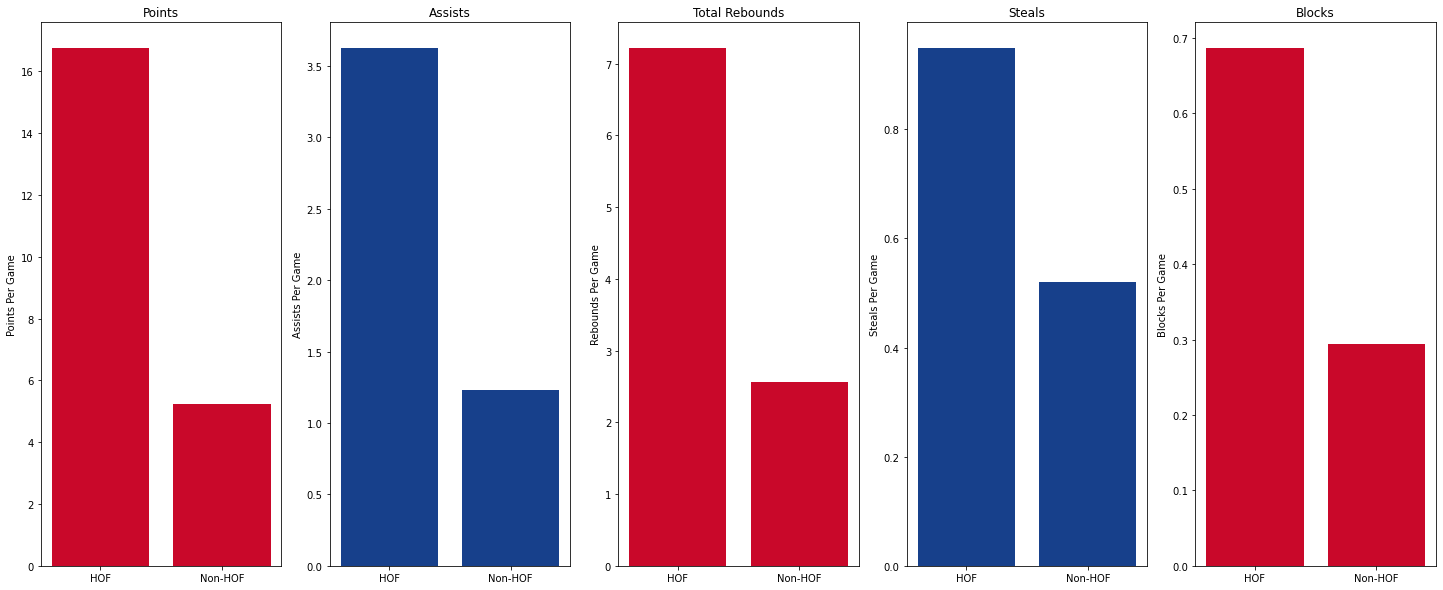

In [142]:

#Splitting data set into hall of famers and non hall of famers
hof = dfOld[dfOld.isInHOF == True]
hof = hof.reset_index(level=0)
nonhof = dfOld[dfOld.isInHOF == False]
nonhof = nonhof.reset_index(level=0)

#Getting the average of both non-hall of famers and hall of famers
pts = [hof.PTS.mean(), nonhof.PTS.mean()]
asts = [hof.AST.mean(), nonhof.AST.mean()]
trb = [hof.TRB.mean(), nonhof.TRB.mean()]
stl = [hof.STL.mean(), nonhof.STL.mean()]
blk = [hof.BLK.mean(), nonhof.BLK.mean()]

plt.figure(figsize=(25, 10))

plt.subplot(1, 5, 1)
plt.title("Points")
plt.ylabel("Points Per Game")
plt.bar(["HOF","Non-HOF"], pts,color='#C9082A')

plt.subplot(1, 5, 2)
plt.title("Assists")
plt.ylabel("Assists Per Game")
plt.bar(["HOF","Non-HOF"], asts ,color='#17408B')

plt.subplot(1, 5, 3)
plt.title("Total Rebounds")
plt.ylabel("Rebounds Per Game")
plt.bar(["HOF","Non-HOF"], trb ,color='#C9082A')

plt.subplot(1, 5, 4)
plt.title("Steals")
plt.ylabel("Steals Per Game")
plt.bar(["HOF","Non-HOF"], stl ,color='#17408B')

plt.subplot(1, 5, 5)
plt.title("Blocks")
plt.ylabel("Blocks Per Game")
plt.bar(["HOF","Non-HOF"], blk ,color='#C9082A')


As you can see, a Hall of Fame player certainly is significatly more dominant than a player who was not inducted in the all of fame (excluding current players who aren't currently eligible). In categories such as points, assists, and rebounds, the Hall of Famers dominate almost trippling the stats of their non Hall of Fame counterparts. In terms of steals and blocks, it appears as if the numbers are a little closer but even then the Hall of Famers numbers are about double their non Hall of Fame counterparts. The statline that appears to be the closest is "Steals" where it appears that non Hall of Famers averaged about 0.5 steals per game compared to about ~0.9 for the Hall of Game group

#### b. Who is the best non Hall of Famer to not make the cut?

Surely not every NBA player who didn't make the Hall of Fame didn't average Hall of Fame stats right? There's bound to be outliers here and there, but just how good was the best player who didn't end up being inducted. 

In [143]:
#Creating the "ELO" category and getting the max player
nonhof['ELO'] = nonhof['PTS'] + nonhof['AST'] + nonhof['TRB'] + nonhof['STL'] + nonhof['BLK']
maxNon = nonhof['ELO'].idxmax()
nonhof.iloc[[maxNon]]

,index,Player,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,TRB,AST,STL,BLK,TOV,PF,PTS,isInHOF,ELO
386,472,Brad Daugherty,68.5,36.5125,6.9,13.0375,0.52725,0.0,0.0,0.104125,6.9,13.025,0.527875,0.52725,5.0125,6.7125,0.745125,9.5625,3.65,0.7625,0.7125,2.7125,2.675,18.8,False,33.4875


<BarContainer object of 2 artists>

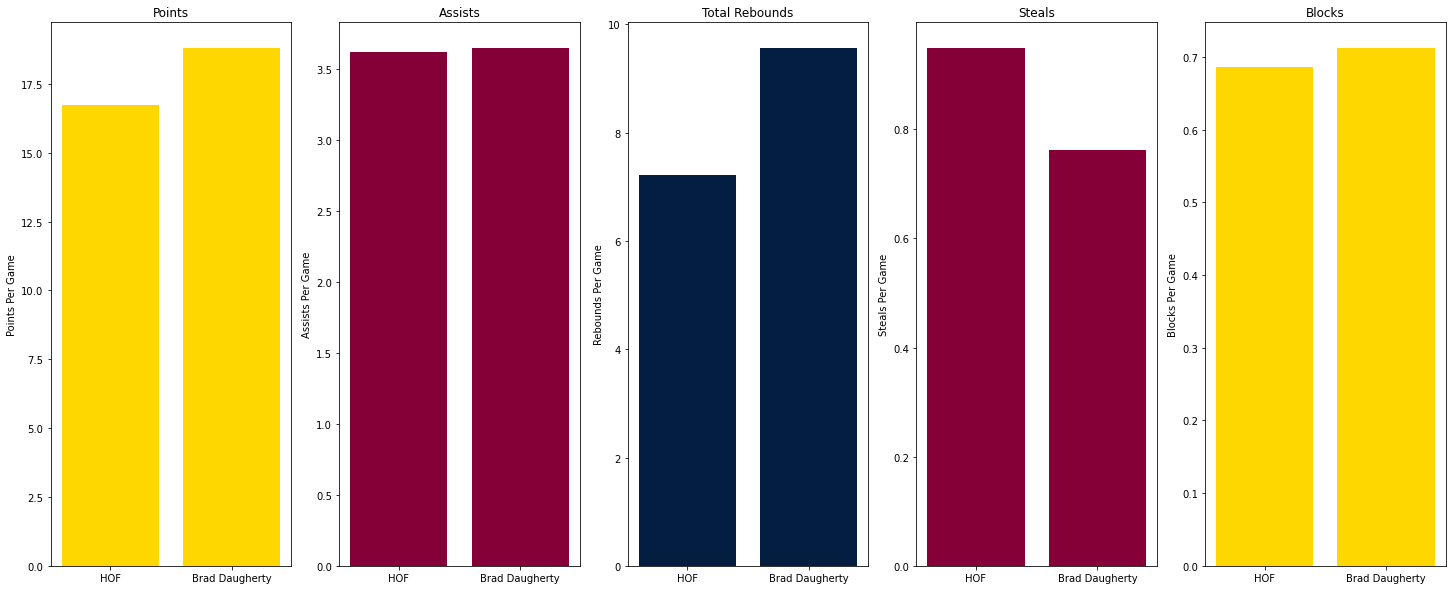

In [144]:
#Comparing the average mean for the Hall of Famers versus the best player (named Brad Daugherty)
pts = [hof.PTS.mean(), nonhof.iloc[maxNon]['PTS']]
asts = [hof.AST.mean(), nonhof.iloc[maxNon]['AST']]
trb = [hof.TRB.mean(), nonhof.iloc[maxNon]['TRB']]
stl = [hof.STL.mean(), nonhof.iloc[maxNon]['STL']]
blk = [hof.BLK.mean(), nonhof.iloc[maxNon]['BLK']]

plt.figure(figsize=(25, 10))

plt.subplot(1, 5, 1)
plt.title("Points")
plt.ylabel("Points Per Game")
plt.bar(["HOF","Brad Daugherty"], pts,color='gold')

plt.subplot(1, 5, 2)
plt.title("Assists")
plt.ylabel("Assists Per Game")
plt.bar(["HOF","Brad Daugherty"], asts ,color='#860038')

plt.subplot(1, 5, 3)
plt.title("Total Rebounds")
plt.ylabel("Rebounds Per Game")
plt.bar(["HOF","Brad Daugherty"], trb ,color='#041E42')

plt.subplot(1, 5, 4)
plt.title("Steals")
plt.ylabel("Steals Per Game")
plt.bar(["HOF","Brad Daugherty"], stl ,color='#860038')

plt.subplot(1, 5, 5)
plt.title("Blocks")
plt.ylabel("Blocks Per Game")
plt.bar(["HOF","Brad Daugherty"], blk ,color='gold')

As you can see, the Hall of Fame isn't a pure metric of stats. Unfortunately for players such as Brad Daugherty who has stats right up there with the best of the best, other factors can lead a player to be inducted into the Hall of Fame that simply aren't measureable such as the impact on the game. There are likely a good amount of players who are outliers in terms of their stats who were given this prestigious honor not for just what they had done on the court but off the court as well. This may impact our choice of machine learning model in the next step.

Fun fact: The colors of the bar graphs represent the team colors Brad Daugherty played most of his career with: The Cleveland Cavaliers!

#### c. Has the NBA evolved to become a faster paced, more offensively skilled game?

People love to claim that today the NBA has essentially become a sprint compared to the tacticality that once was the NBA in the early 1960s. Points are supposedly handed out like candy and defense has become non-existent in the new modern NBA. Let's measure it by looking to see if the average player by era scores more than their older counterparts.

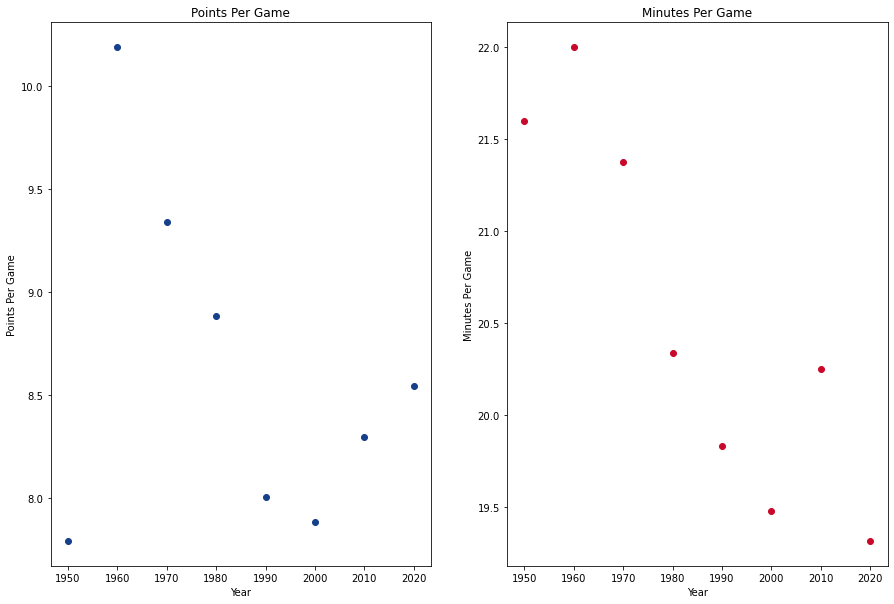

In [145]:
#Splitting every player by decade
df1950 = dfOfPlayers[dfOfPlayers.Year < 1960]
df1960 = dfOfPlayers[dfOfPlayers.Year < 1970]
df1960 = df1960[df1960.Year >= 1960]
df1970 = dfOfPlayers[dfOfPlayers.Year < 1980]
df1970 = df1970[df1970.Year >= 1970]
df1980 = dfOfPlayers[dfOfPlayers.Year < 1990]
df1980 = df1980[df1980.Year >= 1980]
df1990 = dfOfPlayers[dfOfPlayers.Year < 2000]
df1990 = df1990[df1990.Year >= 1990]
df2000 = dfOfPlayers[dfOfPlayers.Year < 2010]
df2000 = df2000[df2000.Year >= 2000]
df2010 = dfOfPlayers[dfOfPlayers.Year < 2020]
df2000 = df2010[df2010.Year >= 2010]
df2020 = dfOfPlayers[dfOfPlayers.Year >= 2020]

#Preparing the values for each decade
decade = [1950,1960,1970,1980,1990,2000,2010,2020]
mp = [df1950.MP.mean(), df1960.MP.mean(), df1970.MP.mean(), df1980.MP.mean(), df1990.MP.mean(), df2000.MP.mean()
      ,df2010.MP.mean(), df2020.MP.mean()]
pts = [df1950.PTS.mean(), df1960.PTS.mean(), df1970.PTS.mean(), df1980.PTS.mean(), df1990.PTS.mean(), df2000.PTS.mean()
      ,df2010.PTS.mean(), df2020.PTS.mean()]

plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.title("Points Per Game")
plt.ylabel("Points Per Game")
plt.xlabel("Year")
plt.scatter(decade, pts, alpha = 1, c = "#17408B")

plt.subplot(1, 2, 2)
plt.title("Minutes Per Game")
plt.ylabel("Minutes Per Game")
plt.xlabel("Year")
plt.scatter(decade, mp, alpha = 1, c = "#C9082A")

From this graph, we can see that it doesn't seem like there seems to be much of a correlation between the decade and the amount of points scored. If anything, we could potentially say that the pace of the game has slowed down if anything taking a large dive in 2000. The theme of the early 2000s basketball was DEFENSE as the Pistons dominated the league with large big men and great defense. They essentially coined the term that "defense wins championships" that is thrown around so often in modern day sports. But if we also look at the minutes per game played as well, we can also see that it is not on an upward trend either in fact it has also been on a downward trend. So this still opens up the question again as we have to look at the average amount of points scored given the average amount of minutes played before we can jump to any solid conclusions.

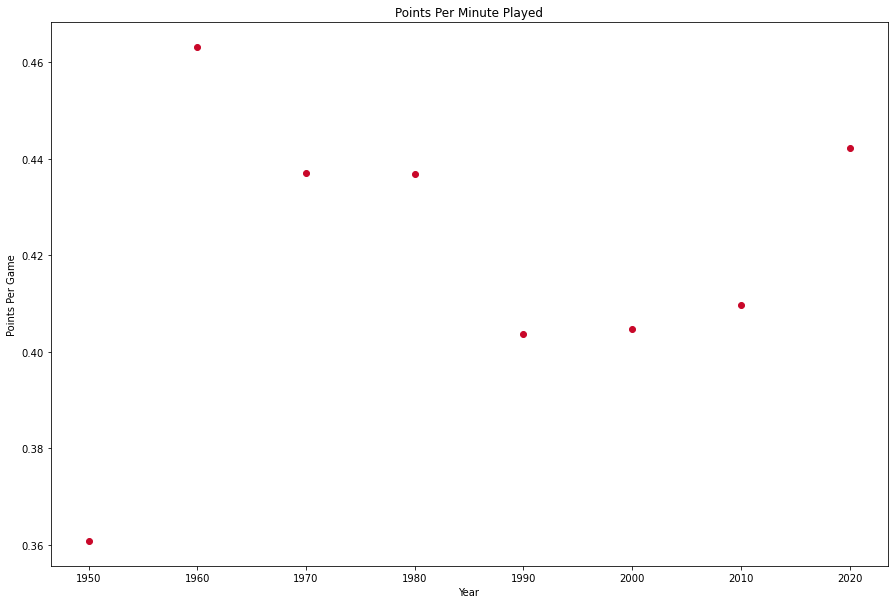

In [146]:
#Getting average point per minute
averagePointsPerMinute = [df1950.PTS.mean()/df1950.MP.mean(), df1960.PTS.mean()/df1960.MP.mean(), 
                          df1970.PTS.mean()/df1970.MP.mean(), df1980.PTS.mean()/df1980.MP.mean(), 
                          df1990.PTS.mean()/df1990.MP.mean(), df2000.PTS.mean()/df2000.MP.mean(),
                          df2010.PTS.mean()/df2010.MP.mean(), df2020.PTS.mean()/df2020.MP.mean()]

plt.figure(figsize=(15, 10))

plt.subplot(1, 1, 1)
plt.title("Points Per Minute Played")
plt.ylabel("Points Per Game")
plt.xlabel("Year")
plt.scatter(decade, averagePointsPerMinute, alpha = 1, c = "#C9082A")

Even when we average out the minutes played with the points per game, we can see there is no general upward trend that would point to todays players being more "skilled" scorers. If anything the 60s had the fastest pace in terms of the relationship between points and minutes played, which leads us to conclude that the NBA today is not any faster paced or more offensively skilled when looking at the output of points and minutes.

#### d. How about defensively? Are there any general trends on the defensive end between decades?

Just like the offensive side, we are going to analyze whether defense has changed throughout the years in the NBA. We're going to create a defensive "ELO" metric which is going to be made up of just blocks and assists similar to how we analyzed who the best players were.

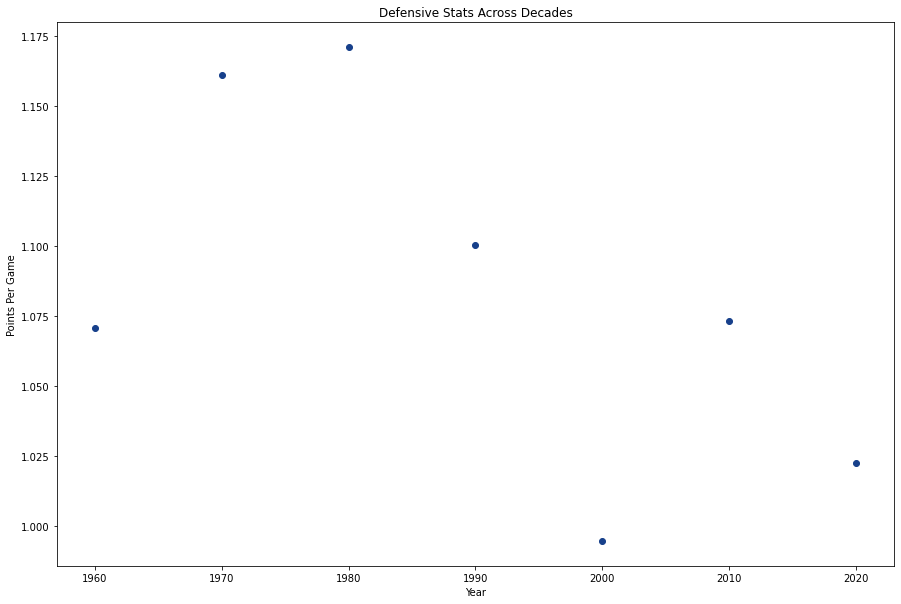

In [147]:
#Getting the defense stats from each category
df1960['defenseELO'] = df1960['STL'] + df1960['BLK']
df1970['defenseELO'] = df1970['STL'] + df1970['BLK']
df1980['defenseELO'] = df1980['STL'] + df1980['BLK']
df1990['defenseELO'] = df1990['STL'] + df1990['BLK']
df2000['defenseELO'] = df2000['STL'] + df2000['BLK']
df2010['defenseELO'] = df2010['STL'] + df2010['BLK']
df2020['defenseELO'] = df2020['STL'] + df2020['BLK']

#Taking the average of defensive elo for every decade
defensedecade = [1960,1970,1980,1990,2000,2010,2020]
averageDefenseELO = [df1960.defenseELO.mean(), 
                          df1970.defenseELO.mean(), df1980.defenseELO.mean(),
                          df1990.defenseELO.mean(), df2000.defenseELO.mean(),
                          df2010.defenseELO.mean(),df2020.defenseELO.mean()]

plt.figure(figsize=(15, 10))

plt.subplot(1, 1, 1)
plt.title("Defensive Stats Across Decades")
plt.ylabel("Points Per Game")
plt.xlabel("Year")
plt.scatter(defensedecade, averageDefenseELO, alpha = 1, c = "#17408B")

There is a common stereotype type that the modern day NBA is simply "softer" nowadays compared to the older NBA leagues. Older fans of the game love to claim this but apparently to some extent it is true. From the graph, we can see that there has been a pretty large jump in "defensiveELO" across the years until it peaks around the 1980s and continues to decline very quickly. This may have been largely due in part to new rules defensive dictating how defense is allowed to be played especially when it comes to using the arms. They ruled that using the arms to guard was now a foul which may have led to less physical play and therefore less steals and blocks overall. It appears that it took a couple years to adjust as blocks and steals almost got halved by the early 2000s, but as seen a slight increase in 2010 and 2020. However based on the graph, we can say that generally there aren't any very obvious trends that follow from 1960-2020 however we can see the effects of things such as defensive rule changes and how they impacted future decades.

#### e. How does the best Hall of Famer compare to the best Non Hall of Famer?

Similarly, as we did with the non-Hall of Famers we're going to narrow down the best current Hall of Famer and compare him to the best non-Hall of Famer just to really see how great some of the players given this honor really are.

In [148]:
#Creating a new ELO column to find the best player overall
hof['ELO'] = hof['PTS'] + hof['AST'] + hof['TRB'] + hof['STL'] + hof['BLK']
maxHOF = hof['ELO'].idxmax()
hof.iloc[[maxHOF]]

,index,Player,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,TRB,AST,STL,BLK,TOV,PF,PTS,isInHOF,ELO
136,4305,Wilt Chamberlain,69.875,45.55,12.425,23.20625,0.559688,0.0,0.0,0.0,12.425,23.20625,0.559688,0.559688,5.8,11.58125,0.495312,22.70625,4.26875,0.665271,0.405254,1.247758,2.025,30.6375,True,58.683025


<BarContainer object of 2 artists>

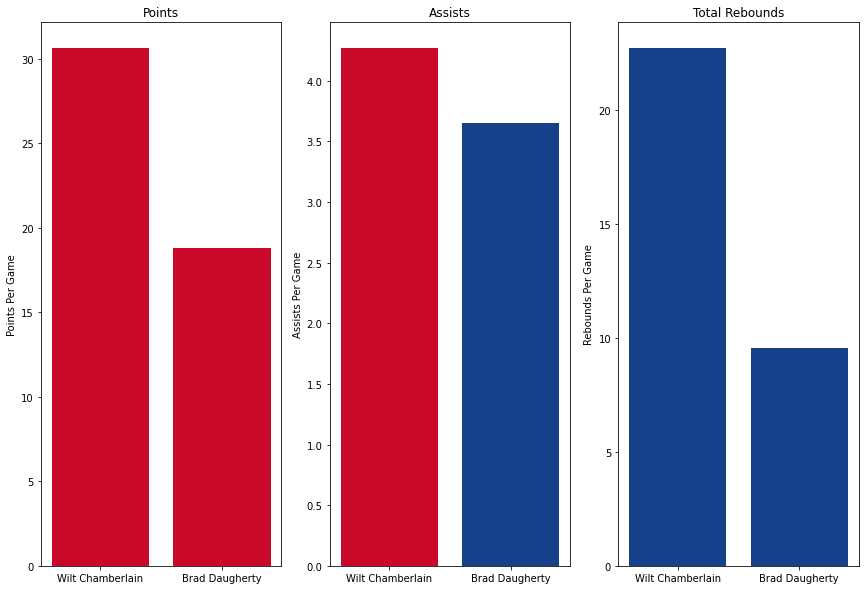

In [149]:
#Adding the HOF and non-HOF stats into a list of their own to be plotted
pts = [hof.iloc[maxHOF]['PTS'], nonhof.iloc[maxNon]['PTS']]
asts = [hof.iloc[maxHOF]['AST'], nonhof.iloc[maxNon]['AST']]
trb = [hof.iloc[maxHOF]['TRB'], nonhof.iloc[maxNon]['TRB']]

plt.figure(figsize=(25, 10))

#Points
plt.subplot(1, 5, 1)
plt.title("Points")
plt.ylabel("Points Per Game")
plt.bar(["Wilt Chamberlain","Brad Daugherty"],pts,color='#C9082A')

#Assists
plt.subplot(1, 5, 2)
plt.title("Assists")
plt.ylabel("Assists Per Game")
plt.bar(["Wilt Chamberlain","Brad Daugherty"], asts ,color=['#C9082A','#17408B'])

#Rebounds
plt.subplot(1, 5, 3)
plt.title("Total Rebounds")
plt.ylabel("Rebounds Per Game")
plt.bar(["Wilt Chamberlain","Brad Daugherty"], trb ,color='#17408B')

#Steals and Blocks were not tracked when Wilt was in the league so I did not opt to include it

The difference between Wilt Chamberlain (the best all-around player on the HOF list) and Brad Daugherty (the best all-around palyer on the non-HOF list) is simpy absurd. Throughout his seasons of play, Chamberlain averaged almost 12 points higher per game than Daugherty, comparable assists, and almost triple the amount of rebounds of Daugherty. We deemed Daugherty one of the best players to not make the Hall of Fame and that based on his stats he is just as good or even better than the average Hall of Famer so the fact that Chamberlain is THIS much more dominant is absurd. 

To put this into a crazier perspective, since the 'ELO' category included points, assists, rebounds, blocks, and steals, and Wilt came from a time before steals and blocks were recorded, the fact that Chamberlain stood on top of all the other Hall of Famers inducted much later than him with none of his actual steal or blocking stats accounted for just shows how dominant Chamberlain was for his era in a way that no other NBA player has been able to match since. The game has just not been the same as Chambelain's age.

** Little fun fact too, Wilt Chamberlain holds the record for the most points in an NBA game at 100 ** 

In [150]:
#Wilt Chamberlain's best career stats:
wilt = pd.DataFrame(dfOfPlayers[dfOfPlayers.Player == 'Wilt Chamberlain'].max()).transpose()
del wilt["Year"]       
wilt

,Player,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,TRB,AST,STL,BLK,TOV,PF,PTS
0,Wilt Chamberlain,82.0,48.5,20.0,39.5,0.727,0.0,0.0,0.0,20.0,39.5,0.727,0.727,10.4,17.0,0.613,27.2,8.6,0.665271,0.405254,1.247758,2.6,50.4


There was once a season where Wilt averaged 50 points a game as well as 27 rebounds!!! 

## 4. Formulating Our Machine Learning Algorithm

Now we're at the bulk of our experiment. Here we're going to experiment with some machine learning algorithms and try to see which one works the best for our dataset. We are going to train and try two classification algorithms and determine which one boasts the highest accuracy. At which point we're going to then apply it to our test set (current players) to see the results

We'll start with K-Nearest Neighbor:

In [151]:
#1 KNN

#Copying our dataframes for KNN
dfOldKNN = dfOld.copy(deep=True)
dfCurrentKNN = dfCurrent.copy(deep=True)

#Get the Hall of Fame values to a list for the "old" HOF players
target = dfOldKNN['isInHOF'].tolist()
#Turn False into 0 and True into 1
target = 1 * np.array(target)

#Deleting the target column as well as the players names
del dfOldKNN["isInHOF"] 
del dfOldKNN["Player"] 
#Converting each row to a list
data = dfOldKNN.values.tolist()

#Splitting our dataset into a train and testing set with train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, target, random_state=1, shuffle=True)

#List for finding the optimal neighbors
training_set_accuracy = []

#Dealing with the optimal amount of neighbors for max accuracy by
#simply iterating through a possible range of between 3-50 neighbors
#in order to find the best value 
for x in range(3,51):
    knn = KNeighborsClassifier(n_neighbors=x)
    train_score = cross_val_score(knn,x_train,y_train,cv=10).mean()
    training_set_accuracy.append(train_score)
    
#Getting amount of neighbors for max accuracy
max_accuracy = max(training_set_accuracy)
max_neighbors = training_set_accuracy.index(max_accuracy)

#Accounting for 0-indexing
max_neighbors = max_neighbors+1
print("Optimal amount of neighbors: " + str(max_neighbors))

#Fitting the best knn model
best_knn = KNeighborsClassifier(n_neighbors=max_neighbors)
best_knn.fit(x_train,y_train)

#Gathering average accuracy on the test data after training on training data
print('General Accuracy: ' + str(best_knn.score(x_test, y_test)))


#Scoring how accurate our KNN algorithm is if we use 10-fold cross validation
scores = cross_val_score(best_knn, data, target, cv=10, scoring='accuracy')
print('Accuracy Given 10-Fold Cross Validation: ' + str(scores.mean()))
print('STD Given 10-Fold Cross Validation: ' + str(scores.std()))

Optimal amount of neighbors: 35
General Accuracy: 0.975609756097561
Accuracy Given 10-Fold Cross Validation: 0.9747568482610033
STD Given 10-Fold Cross Validation: 0.005031983718565917


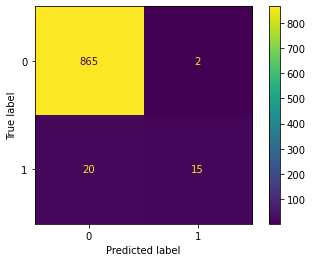

In [152]:
#Creating a confusion matrix based on KNN
y_pred = best_knn.predict(x_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

Based on our KNN algorithm, we get our best accuracy of around 97% when examining around 33-37 of the nearest neighbors with a very small standard deviation when applying 10-Fold Cross Validation. With a dataset this large, an accuracy of this magnitude is very astonishing and there may have been a little bit of overfitting since there is an overwhelming amount of players not in the hall of fame, but given that we tried a different amount of neighbors from 3 all the way to 50 and it settled on a value around 35 for the optimal amount of neighbors, we can conclude that the model is pretty good at predicting if an NBA player is going to be a Hall of Famer given the fact that it trained on 75% of the overall dataset and the other 25% was used as a test.

When looking at the confusion matrix too, we can see the stats are actually pretty good. Precision is actually quite good when considering the true positives and false negatives as we only misclassified 2 people as Hall of Famers when they actually weren't. Recall is a little lower in comparison but even then that isn't too bad either. There are some outliers in the set of Hall of Famers who are not inducted based on their NBA stats alone, but overall I would say the KNN algorithm did a very good job of classifying people into the right categories.

Now let's see which modern day NBA players the KNN algorithm thinks will end up in the Hall of Fame:

In [153]:
#Storing the names of the players to put back later after being put through the machine learning algorithm
names = dfCurrentKNN["Player"].values.tolist()
del dfCurrentKNN["Player"] 
data = dfCurrentKNN.values.tolist()

#Predicting all the players in the dataset and then placing it back into the dataframe
values = best_knn.predict(data)

#Placing the results back in 
dfCurrentKNN['Player'] = names
dfCurrentKNN['willBeInHOF'] = values

#Reorganizing the names so it's the first column
names = dfCurrentKNN['Player']
dfCurrentKNN.drop(labels=['Player'], axis=1,inplace = True)
dfCurrentKNN.insert(0, 'Player', names)

#Filtering out who will not be a future Hall Of Famer
dfCurrentKNN = dfCurrentKNN[dfCurrentKNN.willBeInHOF == 1]
dfCurrentKNN

,Player,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,TRB,AST,STL,BLK,TOV,PF,PTS,willBeInHOF
183,Anthony Davis,62.666667,34.200000,8.822222,17.177778,0.512556,0.511111,1.677778,0.243222,8.288889,15.544444,0.533889,0.526444,5.533333,6.955556,0.790333,10.088889,2.366667,1.388889,2.288889,1.955556,2.322222,23.655556,1
480,Bradley Beal,67.222222,34.477778,7.933333,17.422222,0.451333,2.233333,5.944444,0.379556,5.700000,11.477778,0.489778,0.516111,3.788889,4.588889,0.808778,4.011111,3.966667,1.144444,0.377778,2.355556,2.211111,21.866667,1
623,Carmelo Anthony,63.400000,34.825000,8.160000,18.280000,0.443850,1.380000,3.880000,0.345450,6.780000,14.395000,0.468250,0.483950,5.140000,6.295000,0.812800,6.360000,2.745000,0.955000,0.515000,2.435000,2.860000,22.825000,1
891,Damian Lillard,75.777778,36.344444,8.122222,18.511111,0.438556,3.077778,8.111111,0.374667,5.100000,10.377778,0.489000,0.520667,5.600000,6.255556,0.890000,4.188889,6.666667,0.988889,0.322222,2.811111,1.933333,24.922222,1
1040,DeMar DeRozan,73.416667,34.100000,7.216667,15.683333,0.462500,0.400000,1.450000,0.255250,6.825000,14.241667,0.479500,0.474500,5.341667,6.391667,0.828750,4.341667,3.858333,0.983333,0.300000,2.058333,2.241667,20.175000,1
1125,Devin Booker,68.166667,33.666667,8.083333,17.716667,0.453000,1.983333,5.633333,0.351500,6.066667,12.100000,0.499833,0.509000,5.133333,5.916667,0.867000,3.783333,4.716667,0.800000,0.266667,3.300000,3.000000,23.266667,1
1186,Dirk Nowitzki,72.476190,33.009524,7.133333,15.219048,0.463000,1.290476,3.400000,0.374714,5.861905,11.828571,0.490476,0.507667,4.561905,5.209524,0.870714,7.347619,2.338095,0.785714,0.819048,1.604762,2.338095,20.109524,1
1234,Donovan Mitchell,69.500000,33.700000,8.450000,19.275000,0.439000,2.675000,7.325000,0.363500,5.800000,11.975000,0.485000,0.508000,4.025000,4.900000,0.829750,4.150000,4.350000,1.225000,0.300000,2.750000,2.525000,23.675000,1
1292,Dwyane Wade,62.277778,32.655556,7.605556,15.961111,0.473500,0.500000,1.722222,0.275778,7.105556,14.227778,0.495778,0.489500,4.988889,6.538889,0.756278,4.527778,5.155556,1.472222,0.816667,3.050000,2.172222,20.694444,1
1612,Giannis Antetokounmpo,73.625000,32.475000,7.825000,14.637500,0.520125,0.675000,2.337500,0.275625,7.162500,12.312500,0.564125,0.544125,5.100000,7.150000,0.715625,9.337500,4.550000,1.187500,1.275000,2.875000,2.975000,21.437500,1


Based on the results, we can see that for the most part we got a lot of the big names on the list as needed. People like Lebron James and Dirk Nowitzki who are both players who have had a tremendous impact on the game and  complete locks for the Hall of Fame when they retire are captured by the KNN algorithm. As well, some young players who haven't had the chance to play out a lot of their career but have had a promising start such as Luka Dončić and Trae Young are included on the list, which will be interesting to see as their careers progress. If they continue to perform at the same dominant level they are currently, they will almost certainly be a lock for the Hall of Fame later in their careers. 

An interesting point to note is that the algorithm seems to value 3 pointers and 3 point percentage less than other stats when looking for the nearest neighbors. We seem to be missing one of the greatest 3-point shooters of all-time in Steph Curry from the list even though his points per game and other attributes are seemingly indistinguishable from the playes listed above. Where Curry really stands out is his 3 point shooting which the KNN algorithm seems to overlook compared to other important stats.

This may be due in part to the fact that there are a lot of previous Hall of Famers who were indicted prior to the 3 point line being ruled into existance. Keep in mind again that we set the 3 point attempts to players before the shot was introduced to 0 making it pretty heavily skewed towards 0 as even when it was introduced it saw very little use in the NBA until roughly the early 80s.

Let's look at the Random Forest now:

In [154]:
#2 Random Forest

#Copying our dataframes for KNN
dfOldRF = dfOld.copy(deep=True)
dfCurrentRF = dfCurrent.copy(deep=True)

#Get the Hall of Fame values to a list for the "old" HOF players
target = dfOldRF['isInHOF'].tolist()
#Turn False into 0 and True into 1
target = 1 * np.array(target)

#Deleting the target column as well as the players names
del dfOldRF["isInHOF"] 
del dfOldRF["Player"] 
#Converting each row to a list
data = dfOldRF.values.tolist()

#Splitting data into test and training data
x_train, x_test, y_train, y_test = train_test_split(data, target, random_state=1, shuffle=True)

training_set_accuracy = []

#Dealing with the optimal amount of trees for max accuracy by
#simply brute forcing and iterating through the
#possible range in order to find the best value (model selection)
for x in range(1,51):
    randomforest = RandomForestClassifier(n_estimators = x, random_state = 1)
    train_score = cross_val_score(randomforest,x_train,y_train,cv=10).mean()
    training_set_accuracy.append(train_score)
    
#Getting optimal of trees for max accuracy
max_accuracy = max(training_set_accuracy)
max_trees = training_set_accuracy.index(max_accuracy)
#Accounting for 0-indexing
max_trees = max_trees+1
print("Optimal trees: " + str(max_trees))

training_set_accuracy = [] 

#Dealing with the optimal depth for max accuracy by
#simply brute forcing and iterating through the
#possible range in order to find the best value (model selection)
for x in range(1,21):
    randomforest = RandomForestClassifier(n_estimators = max_neighbors, max_depth = x)
    train_score = cross_val_score(randomforest,x_train,y_train,cv=10).mean()
    training_set_accuracy.append(train_score)
    
#Getting optimal of depth for max accuracy
max_accuracy = max(training_set_accuracy)
maxDepth = training_set_accuracy.index(max_accuracy)
#Accounting for 0-indexing
maxDepth = maxDepth+1
print("Optimal depth: " + str(maxDepth))

#Fitting and training the best random forest model
best_forest =  RandomForestClassifier(n_estimators = max_neighbors, max_depth = maxDepth)
best_forest.fit(x_train,y_train)

#Gathering average accuracy on the test data after training on training data
print('General Accuracy: ' + str(best_forest.score(x_test, y_test)))

#Scoring how accurate our random forest algorithm is if we use 10-fold cross validation
scores = cross_val_score(best_forest, data, target, cv=10, scoring='accuracy')
print('Accuracy Given 10-Fold Cross Validation: ' + str(scores.mean()))
print('STD Given 10-Fold Cross Validation: ' + str(scores.std()))



Optimal trees: 47
Optimal depth: 3
General Accuracy: 0.9745011086474501
Accuracy Given 10-Fold Cross Validation: 0.9764181286549707
STD Given 10-Fold Cross Validation: 0.005996103598554837


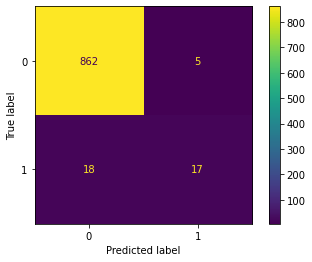

In [155]:
#Creating a confusion matrix based on RF
y_pred = best_forest.predict(x_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

Very similar accuracy to what was seen above with KNN. Random Forests tend to be very good about not overfitting as well we run a test to limit the depth of our decision trees so for the most part the accuracy should be based on real numbers and not be overfitting. Given 10-Fold Cross Validation, we see a very similar accuracy to the general accuracy with a very small standard deviation which is always a good sign. 

Also similar to the KNN when looking at the confusion matrix too, we can see the stats are also actually pretty good. Precision and Recall are very similar compared to KNN, but Random Forest seems to be more generous with the Hall of Fame label and as a result mislabeled 5 people as Hall of Famers when in reality they weren't actually in the Hall of Fame. Overall however, we can see that the Random Forest also does an awesome job when it comes to classifying players as Hall of Famers

Let's now apply our Random Forest to our current players and see who it thinks will be an eventual Hall of Famer:

In [156]:
#Storing the names of the players to put back later after being put through the machine learning algorithm
names = dfCurrentRF["Player"].values.tolist()
del dfCurrentRF["Player"] 
data = dfCurrentRF.values.tolist()

#Predicting all the players in the dataset and then placing it back into the dataframe
values = best_forest.predict(data)

#Placing the results back in 
dfCurrentRF['Player'] = names
dfCurrentRF['willBeInHOF'] = values

#Reorganizing the names so it's the first column
names = dfCurrentRF['Player']
dfCurrentRF.drop(labels=['Player'], axis=1,inplace = True)
dfCurrentRF.insert(0, 'Player', names)

#Filtering out who will not be a future Hall Of Famer
dfCurrentRF = dfCurrentRF[dfCurrentRF.willBeInHOF == 1]
dfCurrentRF

,Player,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,TRB,AST,STL,BLK,TOV,PF,PTS,willBeInHOF
159,Andrew Wiggins,64.333333,35.055556,7.388889,16.555556,0.447000,1.500000,4.333333,0.335333,5.911111,12.188889,0.486667,0.491222,3.633333,5.066667,0.715333,4.577778,2.700000,0.977778,0.800000,2.122222,2.200000,19.911111,1
183,Anthony Davis,62.666667,34.200000,8.822222,17.177778,0.512556,0.511111,1.677778,0.243222,8.288889,15.544444,0.533889,0.526444,5.533333,6.955556,0.790333,10.088889,2.366667,1.388889,2.288889,1.955556,2.322222,23.655556,1
368,Blake Griffin,51.466667,32.586667,7.026667,14.893333,0.468067,1.046667,3.200000,0.307800,5.973333,11.706667,0.505867,0.507200,4.073333,5.680000,0.724800,7.586667,4.340000,0.786667,0.433333,2.346667,2.626667,19.153333,1
480,Bradley Beal,67.222222,34.477778,7.933333,17.422222,0.451333,2.233333,5.944444,0.379556,5.700000,11.477778,0.489778,0.516111,3.788889,4.588889,0.808778,4.011111,3.966667,1.144444,0.377778,2.355556,2.211111,21.866667,1
623,Carmelo Anthony,63.400000,34.825000,8.160000,18.280000,0.443850,1.380000,3.880000,0.345450,6.780000,14.395000,0.468250,0.483950,5.140000,6.295000,0.812800,6.360000,2.745000,0.955000,0.515000,2.435000,2.860000,22.825000,1
891,Damian Lillard,75.777778,36.344444,8.122222,18.511111,0.438556,3.077778,8.111111,0.374667,5.100000,10.377778,0.489000,0.520667,5.600000,6.255556,0.890000,4.188889,6.666667,0.988889,0.322222,2.811111,1.933333,24.922222,1
1040,DeMar DeRozan,73.416667,34.100000,7.216667,15.683333,0.462500,0.400000,1.450000,0.255250,6.825000,14.241667,0.479500,0.474500,5.341667,6.391667,0.828750,4.341667,3.858333,0.983333,0.300000,2.058333,2.241667,20.175000,1
1042,DeMarcus Cousins,51.357143,28.957143,6.800000,14.857143,0.457286,0.935714,2.714286,0.278571,5.871429,12.135714,0.486571,0.491929,4.742857,6.385714,0.736429,9.928571,3.157143,1.292857,1.114286,3.135714,3.592857,19.285714,1
1186,Dirk Nowitzki,72.476190,33.009524,7.133333,15.219048,0.463000,1.290476,3.400000,0.374714,5.861905,11.828571,0.490476,0.507667,4.561905,5.209524,0.870714,7.347619,2.338095,0.785714,0.819048,1.604762,2.338095,20.109524,1
1288,Dwight Howard,69.529412,31.976471,5.782353,9.841176,0.594824,0.005882,0.064706,0.143882,5.770588,9.770588,0.598706,0.596059,4.335294,7.670588,0.563059,11.858824,1.329412,0.882353,1.741176,2.682353,3.229412,15.929412,1


Interestingly enough, the Random Forest actually picked out a lot more names than our KNN classifier. A lot of the same pretty much guaranteed Hall of Famer names were picked from the KNN classification minus one or two various people. However, we also see the inclusion of the infamous Stephen Curry, one of the greatest 3-point NBA shooters of all time and a guarantee for the Hall of Fame. 

The Random Forest likely took 3-pointers more into account than the KNN classifer explaining the inclusion of other players who are pretty good shooters such as Collin Sexton and John Wall. Interestingly enough too, there seem to be a larger variety of power forwards and centers in the data set as well with the inclusion of a lot of players who could potentially be Hall of Famers such as Dwight Howard making me think they put more weights on elite rebounders than the KNN classifier. There is also once again a pretty good spread of young players with the algorithm even poking out Zion Williamson who is a very young and promising NBA player, yet mildly injury prone early in his first couple seasons. 

For the most part however it seems as if the Random Forest classifier seems to be more accurate in terms of our general intuitions on who is going to end up in the Hall Of Fame. It certainly grabbed a lot more players who seem to be "on the edge" of being a potential Hall of Famer (depending on other factors that can't be measured such as impact off the court) but in exchange for grabbing guaranteed Hall of Famers such as Steph Curry which the KNN algorithm missed. It will be interesting however to see how this plays out in the future once a lot of these guys have retired and potentially get inducted within the next decade!

## 5. Conclusion

It takes a lot to be a Hall of Famer in the NBA. Not only do you have to be one of the most dominant players that the league has ever seen, but you have to dominate for many years to be considered by many to be a guarantee. Even though there are other ways to make the league that are immeasurable such as impact off the court in the case of players like Yao Ming (one of the 1st Chinese-Americans to play in the league!) or Chuck Cooper (1st African-American to play in the league). No matter what however every player inducted into the Hall of Fame has a story like no other whether it be dominance on the court or off. Hopefully in a couple decades we can cross reference how well both the machine learning algorithms did and determine how correct it was in its predictions. But for now, let's watch some basketball!

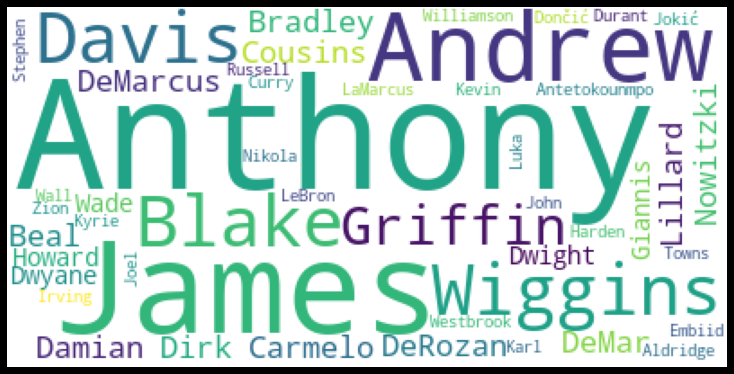

In [157]:
#Creating word cloud for the players
names = list(dfCurrentRF['Player'])
plt.figure(figsize=(10,10), facecolor='k')
wordcloud = WordCloud(background_color='white').generate(" ".join(names))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Word cloud of the most common names in our predicted Hall of Famers :) 